In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
import seaborn as sns
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
try:
  from google.colab import drive 
  drive.mount('/content/gdrive')
except:
  pass

Mounted at /content/gdrive


In [42]:
# df = pd.read_csv('train_indessa.csv')
try:
  df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train_indessa.csv')
  df_test=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test_indessa.csv')
except:
  df = pd.read_csv('train_indessa.csv')
  df_test = pd.read_csv('test_indessa.csv')

### Analysis

In [32]:
def simple_scatter(df,X,Y):
  plt.figure(figsize=(18,14))
  plt.scatter(df[X],df[Y])
  plt.xlabel(X)
  plt.ylabel(Y)

def null_values(df):
  mis_val = df.isnull().sum()
  mis_val_percent = 100 * df.isnull().sum() / len(df)
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% of Total Values', ascending=False).round(1)
  print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
  return mis_val_table_ren_columns

def scatter_hue(df,X, Y, hue):
  plt.figure(figsize=(18,14))
  for each in df[hue].unique():
    plt.scatter(df[df[hue]==each][X], df[df[hue]==each][Y], label=each)
  plt.legend()
  plt.xlabel(X)
  plt.ylabel(Y)

def master_scatter(df,X, Y, hue=None):
  if hue == None:
    simple_scatter(df,X, Y)
  else:
    scatter_hue(df,X, Y, hue)

def box_plot(df, Y, hue):
  plt.figure(figsize=(12,8))
  data = []
  for each in df[hue].unique():
    data.append(df[df[hue]==each][Y])
  plt.boxplot(data)
  plt.legend()
  plt.xticks([1,2], labels = df[hue].unique())
  plt.xlabel(hue)
  plt.ylabel(Y)

def employment(value):
  value = value.replace('<','').replace('+','')
  value = value.split()[0]
  return int(value)

def week_pay(value):
  value = value.split()[0].replace('th','')
  try:
    return int(value)
  except:
    return None

def dummies(df):
  for feature in tqdm(one_hot_features):
    df = df.join(pd.get_dummies(df[feature],prefix=feature, drop_first=True))
    df.drop(feature, axis=1, inplace=True)
  return df

def int_encode(df_fit, df_transform=None):
  from sklearn import preprocessing
  for feature in tqdm(one_hot_features):
    le = preprocessing.LabelEncoder()
    df_fit[feature] = le.fit_transform(df_fit[feature])

    df_transform[feature] = le.transform(df_transform[feature])
  return df_fit, df_transform
    

def split_train_val(X, y):
  kfold = StratifiedKFold(n_splits=4)
  for train_ix, test_ix in kfold.split(X,y):
    train_X, test_X = X[train_ix,:], X[test_ix,:]
    train_y, test_y = y[train_ix,:], y[test_ix,:]
  return train_X, test_X, train_y, test_y

tqdm.pandas()

In [6]:
df.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


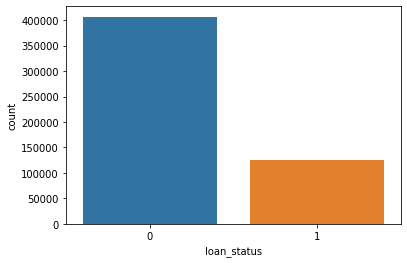

In [7]:
sns.countplot(df['loan_status'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


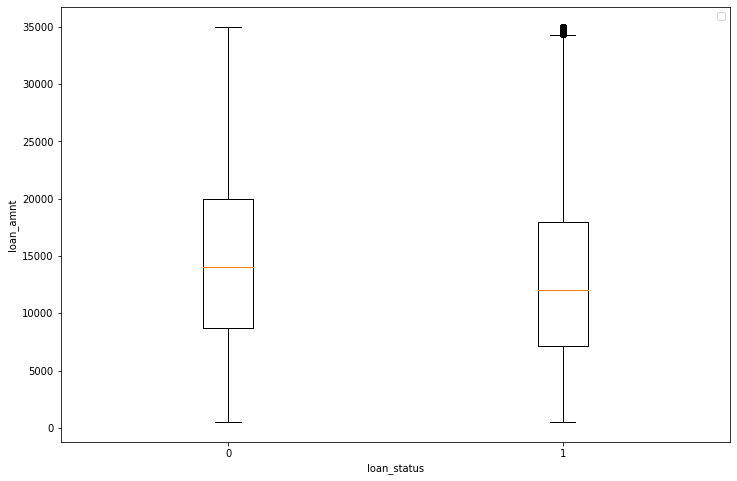

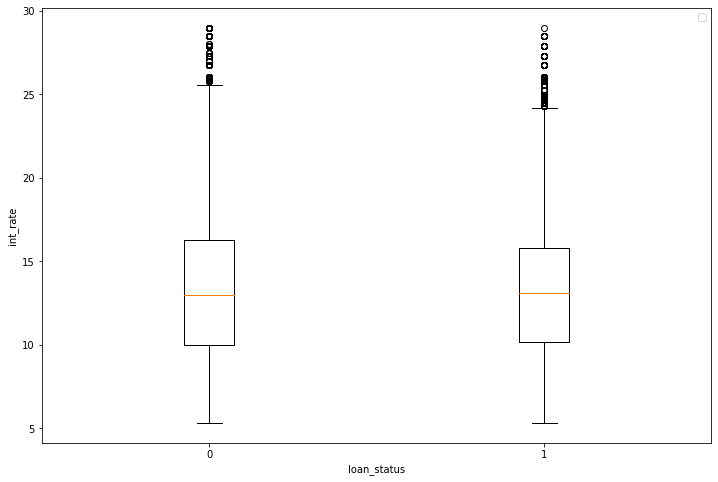

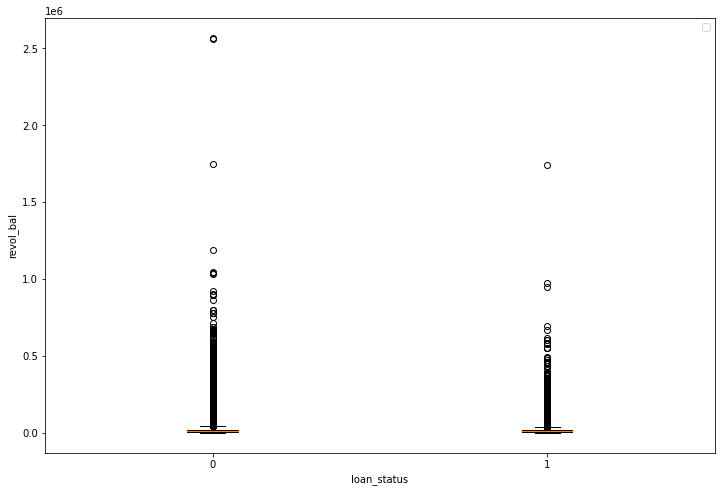

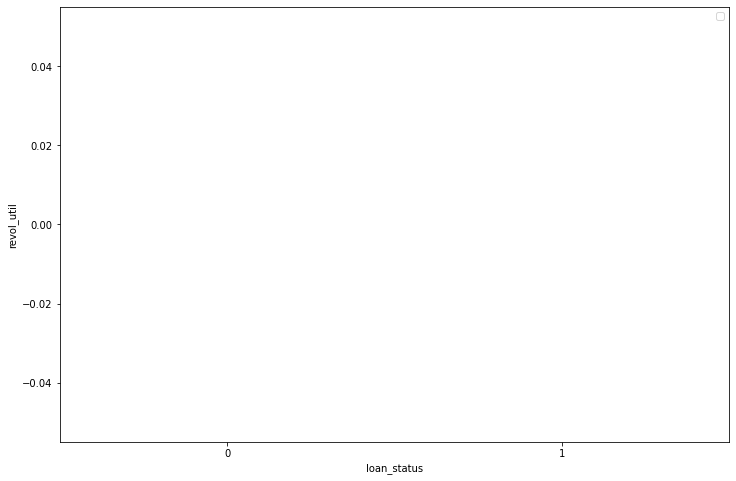

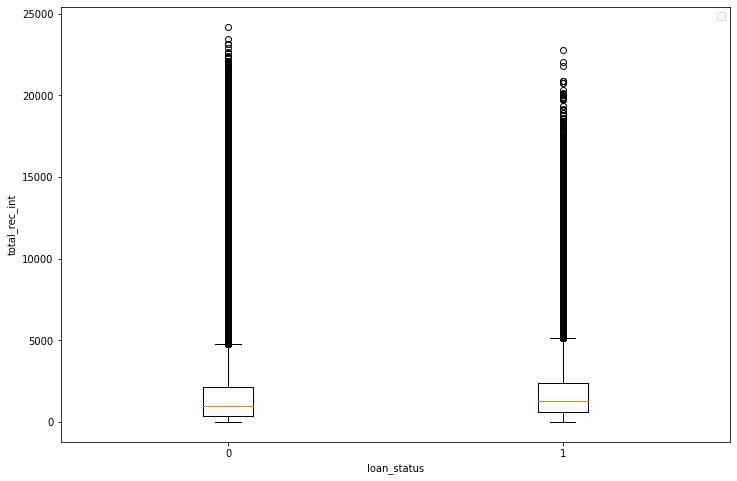

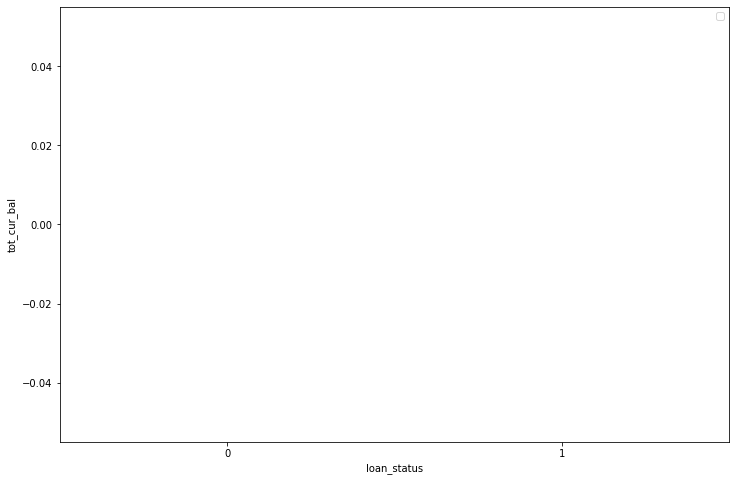

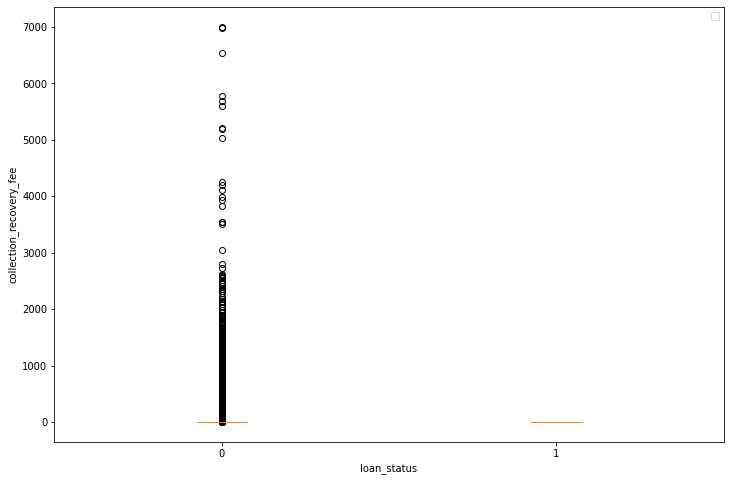

In [33]:
# box_plot(df, 'loan_amnt', 'loan_status')
# box_plot(df, 'int_rate', 'loan_status')
# box_plot(df, 'revol_bal', 'loan_status')
for y in ['loan_amnt', 'int_rate', 'revol_bal', 'revol_util', 'total_rec_int', 'tot_cur_bal', 'collection_recovery_fee']:
  box_plot(df, y, 'loan_status')

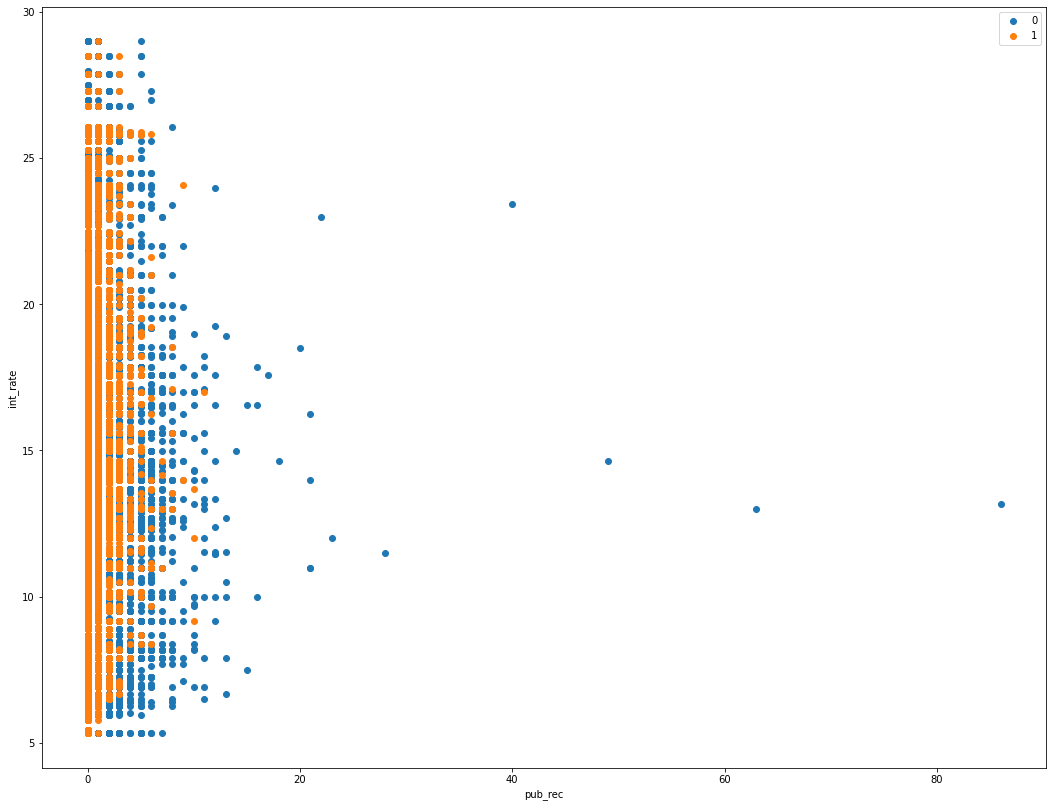

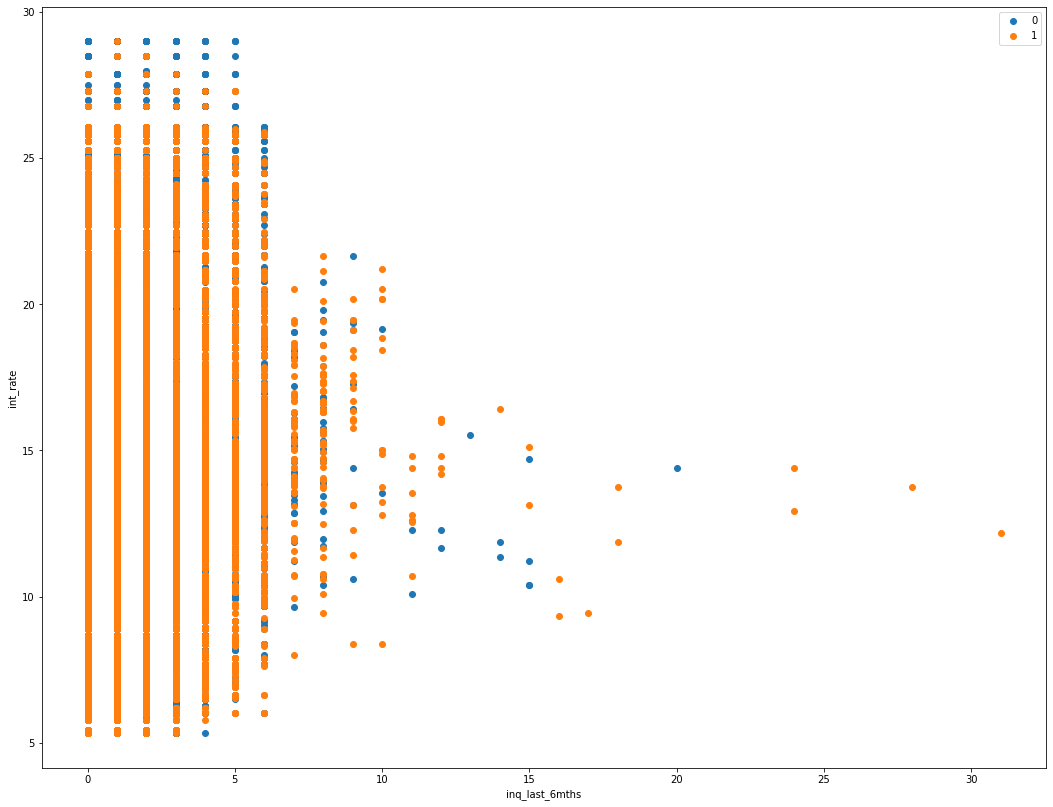

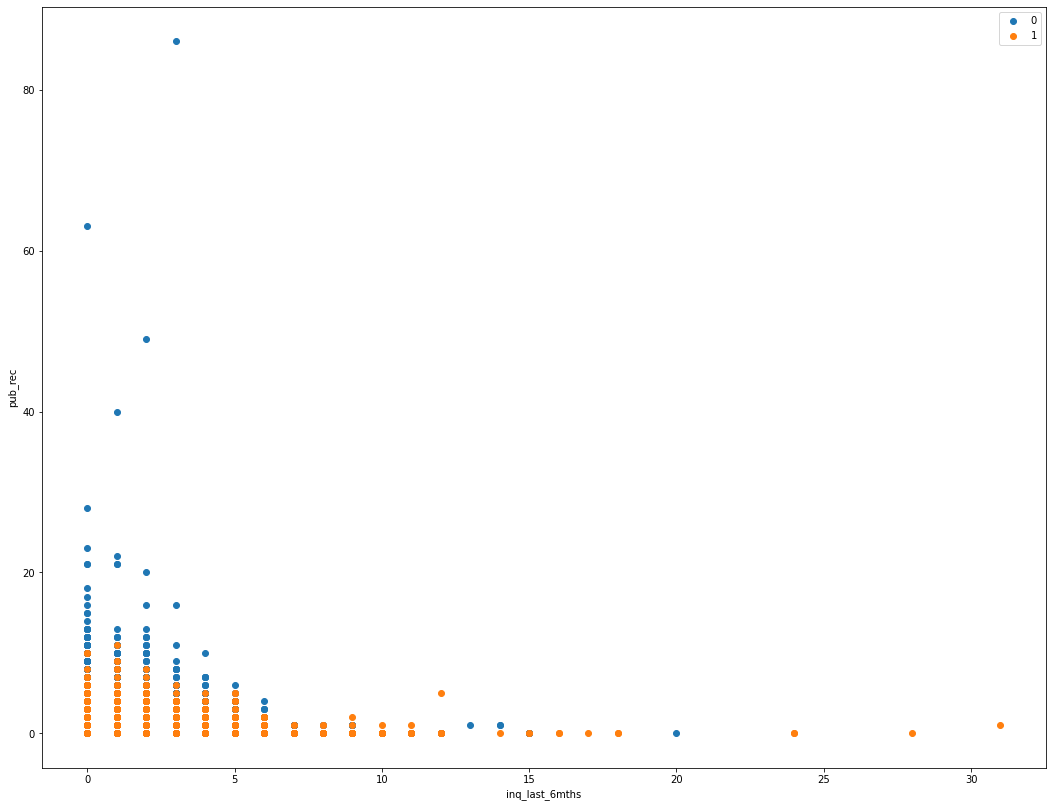

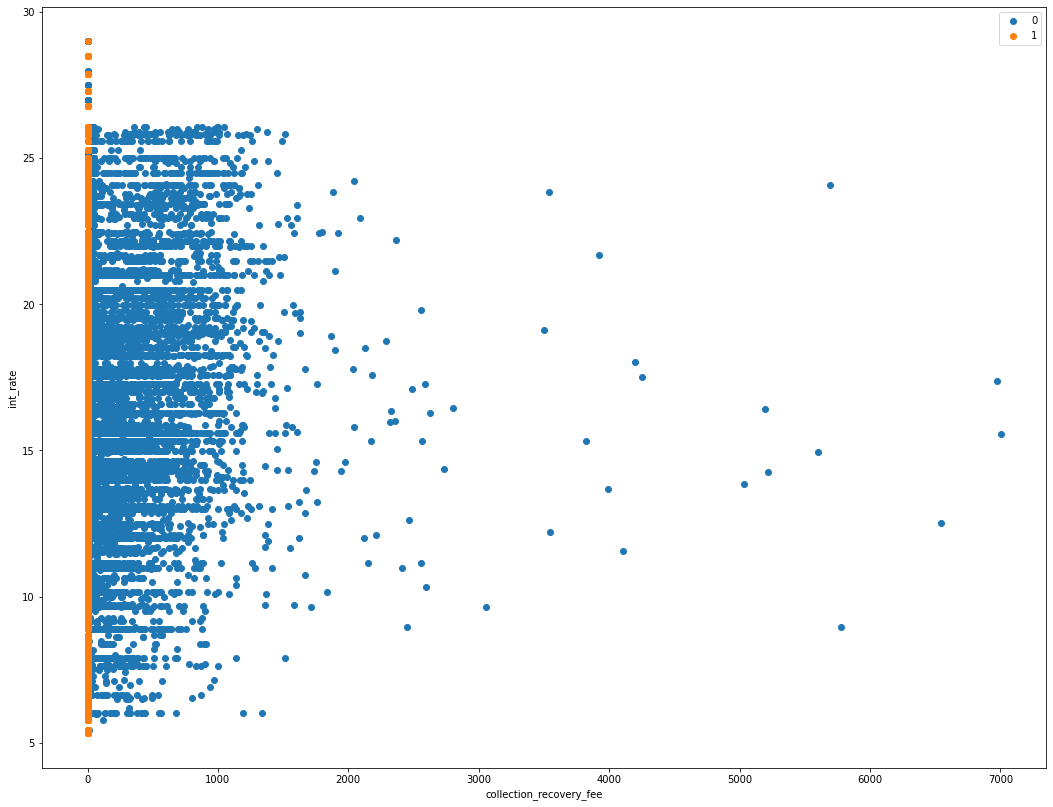

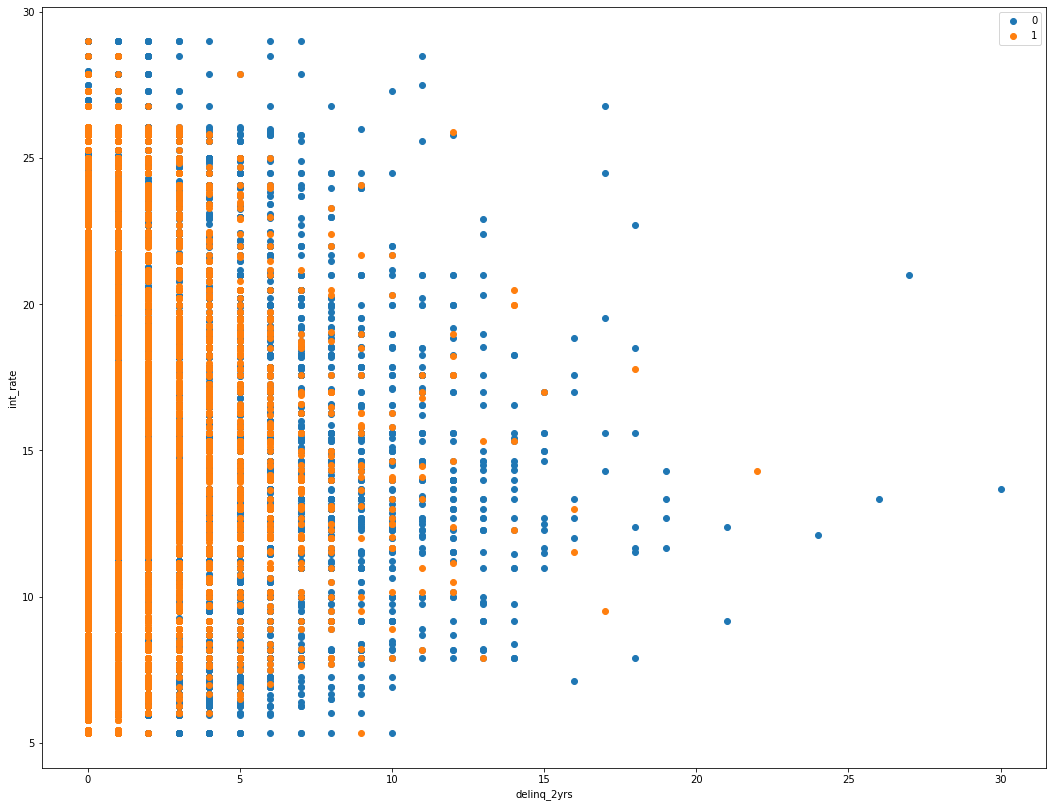

In [34]:
master_scatter(df, 'pub_rec','int_rate', 'loan_status')
master_scatter(df, 'inq_last_6mths','int_rate', 'loan_status')
master_scatter(df, 'inq_last_6mths','pub_rec', 'loan_status')
master_scatter(df, 'collection_recovery_fee','int_rate', 'loan_status')
master_scatter(df, 'delinq_2yrs','int_rate', 'loan_status')



### Data Preparation

In [23]:
mean_impute_cols = ['tot_cur_bal', 'tot_coll_amt','annual_inc','total_rev_hi_lim']
mode_impute_cols = ['emp_length','collections_12_mths_ex_med','acc_now_delinq','pub_rec','total_acc','open_acc','inq_last_6mths','delinq_2yrs']
zero_impute_cols = ['revol_util']

features = ['loan_amnt','term','int_rate','grade','emp_length','home_ownership','annual_inc','verification_status','purpose','dti','delinq_2yrs',
            'inq_last_6mths','open_acc','pub_rec', 'revol_bal', 'revol_util','total_acc','initial_list_status', 'total_rec_int','total_rec_late_fee',
            'recoveries', 'collection_recovery_fee','collections_12_mths_ex_med', 'application_type', 'last_week_pay',
            'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
label = ['loan_status']
one_hot_features = ['grade','home_ownership','verification_status','purpose','initial_list_status','application_type']

def get_impute_param():
  mean_impute_values = []
  mode_impute_values=[]
  for col in mean_impute_cols:
    mean_impute_values.append(df[col].mean())
  for col in mode_impute_cols:
    mode_impute_values.append(df[col].value_counts().index[0])
  return mean_impute_values, mode_impute_values

mean_impute_values, mode_impute_values = get_impute_param()

def prepare_data(df, test=False):

  ## Drop null columns
  drop_cols = list(null_values(df).head(6).index)
  df = df.drop(drop_cols, axis=1)
  print(df.shape)

  ## Null impute
  impute_cols = [col for col in null_values(df).index if col not in drop_cols]
  mean_impute_cols = ['tot_cur_bal', 'tot_coll_amt','annual_inc','total_rev_hi_lim']
  mode_impute_cols = ['emp_length','collections_12_mths_ex_med','acc_now_delinq','pub_rec','total_acc','open_acc','inq_last_6mths','delinq_2yrs']
  zero_impute_cols = ['revol_util']

  for i, col in enumerate(mean_impute_cols):
    df[col] = df[col].fillna(mean_impute_values[i])
  for i, col in enumerate(mode_impute_cols):
    df[col] = df[col].fillna(mode_impute_values[i])
  for col in zero_impute_cols:
    df[col] = df[col].fillna(0)
  print(df.shape)

  df['term'] = df['term'].apply(lambda x: int(x.split()[0]))
  df['emp_length'] = df['emp_length'].progress_apply(employment)
  df['last_week_pay'] = df['last_week_pay'].progress_apply(week_pay)
  df['last_week_pay'] = df['last_week_pay'].fillna(df['last_week_pay'].mean())
  print(df.shape)

  if test == False:
    df = df[features+label]
  if test == True:
    df = df[features]
  print(df.shape)
  # df = dummies(df)
  print(df.shape)
  return df

In [43]:
df = prepare_data(df)
df_test_ids = df_test['member_id']
df_test = prepare_data(df_test, test=True)
df, df_test = int_encode(df, df_test)
# df_test['home_ownership_MORTGAGE'] = 0

Dataframe has 45 columns.
There are 21 columns that have missing values.
(532428, 39)
Dataframe has 39 columns.
There are 15 columns that have missing values.
(532428, 39)


100%|██████████| 532428/532428 [00:00<00:00, 540520.40it/s]


(532428, 39)
(532428, 30)
(532428, 30)
Dataframe has 44 columns.
There are 21 columns that have missing values.
(354951, 38)
Dataframe has 38 columns.
There are 15 columns that have missing values.
(354951, 38)


  0%|          | 0/6 [00:00<?, ?it/s]

(354951, 38)
(354951, 29)
(354951, 29)


100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


### Cross validaion

In [ ]:
model = ModelTrain(df, [col for col in df.columns if col not in label], label)
param_grid_rf = {'n_estimators': [100], 'max_depth': [35], 'min_samples_leaf' : [5], 'max_features': [25]}
param_grid_xgb = {'n_estimators': [100], 'max_depth': [25,30,35], 'min_samples_leaf' : [5], 'max_features': [20,25,30], 'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001]}
param_grid_svc = {'C': [1], 'kernel': ['linear', 'poly', 'rbf']}

print("-------------------Starting Random Forest------------------")
model.choose_algo('rf')
model.cross_val(parameters=param_grid_rf)
model.predict(with_threshold=True)

print("-------------------Starting XGBoost------------------")
model.choose_algo('xgb')
model.cross_val(parameters=param_grid_xgb)
model.predict(with_threshold=True)

print("-------------------Starting SVM------------------")
model.choose_algo('svm')
model.cross_val(parameters=param_grid_svc)
model.predict(with_threshold=True)

### Best Model

In [49]:
## XGboost model

X, y = np.array(df[[col for col in df.columns if col not in label]]), np.array(df[label])
train_X, test_X, train_y, test_y = split_train_val(X, y)

params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf' : 5, 'max_features': 25, 'learning_rate': 0.1}
model = XGBClassifier(**params)
model.fit(np.array(df[[col for col in df.columns if col not in label]]), np.array(df[label]))
# model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              max_features=25, min_child_weight=1, min_samples_leaf=5,
              missing=None, n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [50]:
joblib.dump(model, '/content/gdrive/MyDrive/Colab Notebooks/best_xgb_lab.pkl')

['/content/gdrive/MyDrive/Colab Notebooks/best_xgb_lab.pkl']

### Feature Importance

In [51]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.get_booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = np.sum(list(imp_dict.values()))
    return {k:v/total for k,v in imp_dict.items()}
try:
  model = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/best_xgb_lab.pkl')
except:
  model = joblib.load('best_xgb_lab.pkl')
fea_imp = get_xgb_imp(model, list(df_test.columns))
pd.DataFrame({'feature': list(fea_imp.keys()), 'values': list(fea_imp.values())}).sort_values('values', ascending=False)

,feature,values
9,dti,0.089415
2,int_rate,0.088890
18,total_rec_int,0.083316
15,revol_util,0.081487
27,tot_cur_bal,0.078067
6,annual_inc,0.071930
14,revol_bal,0.071664
24,last_week_pay,0.068047
28,total_rev_hi_lim,0.061591
16,total_acc,0.060313


Text(0.5, 1.0, 'XGB feature importances')

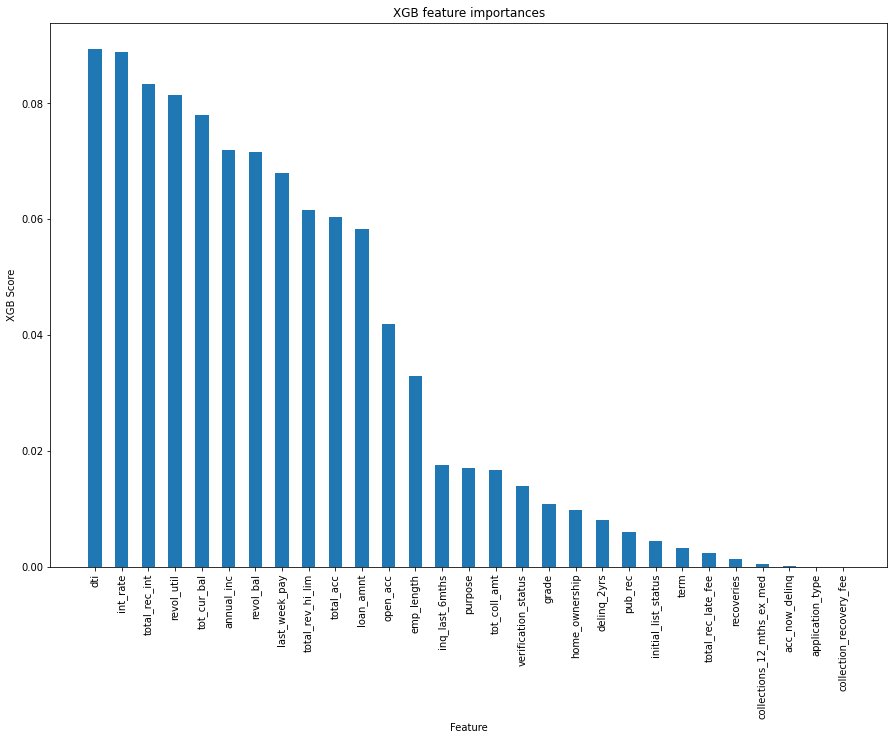

In [52]:
feat = pd.DataFrame({'feature': list(fea_imp.keys()), 'values': list(fea_imp.values())}).sort_values('values', ascending=False)
plt.figure(figsize=(15,10))
plt.bar(feat['feature'], feat['values'], width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('XGB Score')
plt.title('XGB feature importances')

In [53]:
pred = model.predict_proba(test_X)
roc_auc_score(test_y, pred[:,1])

0.9991314130966278

In [54]:
predictions = model.predict_proba(np.array(df_test))[:,1]

In [55]:
submission = pd.DataFrame({'member_id': df_test_ids, 'loan_status': predictions})

In [56]:
try:
  submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/submissions.csv')
except:
  submission.to_csv('submissions.csv')
